# Normalizing Flows 1 : Density Estimation

## Librairies

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
from scipy.stats import multivariate_normal

import matplotlib.pyplot as plt

## Multimodal data illustration

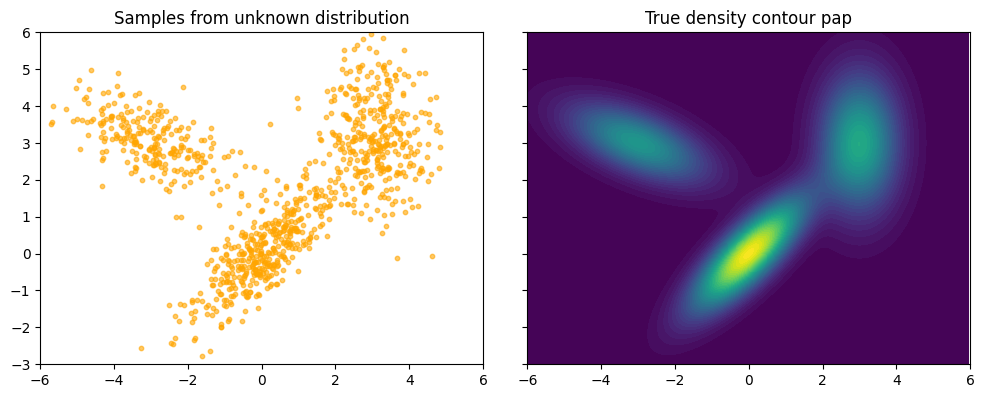

In [28]:
# Set random seed
np.random.seed(42)

# Define Gaussian mixture parameters (stretched)
means = [np.array([0, 0]), np.array([3, 3]), np.array([-3, 3])]
covs = [
    np.array([[1.0, 0.8], [0.8, 1.0]]),
    np.array([[0.5, 0.0], [0.0, 1.5]]),
    np.array([[1.5, -0.5], [-0.5, 0.5]])
]
weights = [0.4, 0.35, 0.25]
n_samples = 1000

# Generate samples
data = np.vstack([
    np.random.multivariate_normal(mean, cov, size=int(weight * n_samples))
    for mean, cov, weight in zip(means, covs, weights)
])

# Create a grid for contour plotting
x, y = np.mgrid[-6:6:.05, -3:6:.05]
pos = np.dstack((x, y))
z = sum(w * multivariate_normal(mean=m, cov=c).pdf(pos)
        for m, c, w in zip(means, covs, weights))

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True, gridspec_kw={'width_ratios': [1, 1]})

# Scatter plot
axes[0].scatter(data[:, 0], data[:, 1], s=10, c="orange", alpha=0.6)
axes[0].set_title("Samples from unknown distribution")
axes[0].set_xlim([-6, 6])
axes[0].set_ylim([-3, 6])
axes[0].set_aspect('equal')
axes[0].grid(False)

# Contour plot
c = axes[1].contourf(x, y, z, levels=50, cmap='viridis')
axes[1].set_title("True density contour pap")
axes[1].set_xlim([-6, 6])
axes[1].set_ylim([-3, 6])
axes[1].set_aspect('equal')
axes[1].grid(False)

# Separate colorbar to avoid resizing plot
# cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
# fig.colorbar(c, cax=cbar_ax)

plt.subplots_adjust(wspace=0.1, right=0.9)
plt.show()

## Dataset

In [2]:
torch.manual_seed(42)

def generate_data(n=10000, x=8, n_modes=4):

    if n_modes == 1:
        modes = [(0, 0)]

    elif n_modes == 2:
        modes = [(-x, -x), 
                 (x, x)]
        
    elif n_modes == 3:
        modes = [(-x, -x), 
                 (x, -x),
                 (0, x)]
         
    elif n_modes == 4:
        modes = [(-x, -x), 
                 (x, x), 
                 (-x, x), 
                 (x, -x)]
    cov = 0.5 * np.eye(2)
    data = []
    for cx, cy in modes:
        samples = np.random.multivariate_normal([cx, cy], cov, n // len(modes))
        data.append(samples)
        
    X = torch.from_numpy(np.vstack(data))
    return X.to(torch.float32)

## Model

In [4]:
class LogDensityMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.net(x).squeeze()  # Output shape: (batch,)

## Training

In [5]:
def train_model(X, n_steps=25000, verbose=True):

    model = LogDensityMLP()
    optimizer = optim.Adam(model.parameters(), lr=1e-5)
    
    n_steps = 20000
    batch_size = 256
    
    for step in range(n_steps):
        idx = np.random.choice(len(X), batch_size)
        x_batch = X[idx]
    
        output = model(x_batch)
        loss = -output.mean()  # Maximize log-density
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if verbose:
            if (step + 1) % 1000 == 0:
                print(f"Step {step+1}, Loss: {loss.item():.4f}")

    return model

In [98]:
def plot(model, X, limit=20, mode="combined"):
    
    # Make a 2D grid
    x = np.linspace(-limit, limit, 200)
    y = np.linspace(-limit, limit, 200)
    X_grid, Y_grid = np.meshgrid(x, y)
    grid = np.stack([X_grid.ravel(), Y_grid.ravel()], axis=-1)
    grid_tensor = torch.tensor(grid, dtype=torch.float32)

    # Predict log-densities
    with torch.no_grad():
        if isinstance(model(grid_tensor), tuple):
            log_probs = model(grid_tensor)[1].numpy()
        else:
            log_probs = model(grid_tensor).numpy()
        probs = np.exp(log_probs - log_probs.max())  # Normalize for plotting!
    
    # Plot contours    
    if mode == "data_only":
        plt.figure(figsize=(5.5,5.5))
        probs = np.zeros_like(probs) * np.nan
    else:
        plt.figure(figsize=(7,6))
        
    plt.contourf(X_grid, Y_grid, probs.reshape(200, 200), levels=50, cmap="viridis")
    if mode != "data_only":
        cbar = plt.colorbar()
    plt.scatter(X[:, 0], X[:, 1], marker=".", c='orange', alpha=0.25)
    plt.xlim(-limit, limit)
    plt.ylim(-limit, limit)
    # plt.title("Learned density")
    # plt.axis("equal")
    # plt.legend()
    plt.show()

## Experiments

In [99]:
X_1 = generate_data(n_modes=1)
model_1 = train_model(X_1, verbose=False)

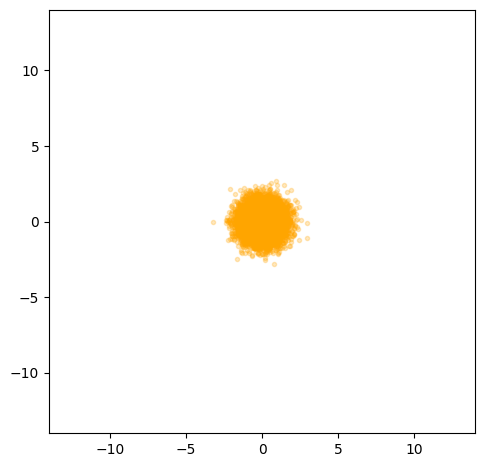

In [100]:
plot(model_1, X_1, limit=14, mode="data_only")

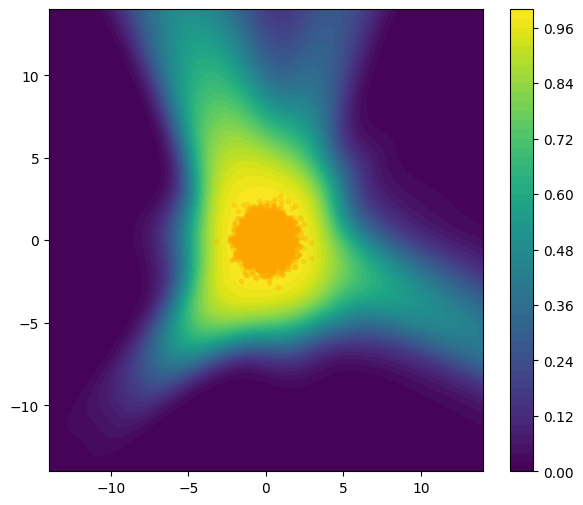

In [101]:
plot(model_1, X_1, limit=14)

In [70]:
X_2 = generate_data(n_modes=2)
model_2 = train_model(X_2, verbose=False)

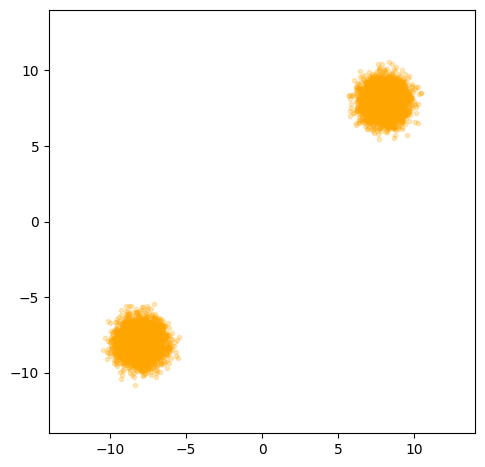

In [71]:
plot(model_2, X_2, limit=14, mode="data_only")

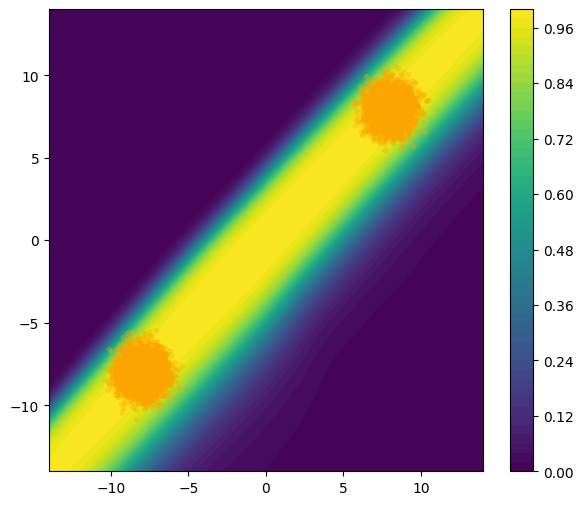

In [72]:
plot(model_2, X_2, limit=14)

In [73]:
X_3 = generate_data(n_modes=3)
model_3 = train_model(X_3, verbose=False)

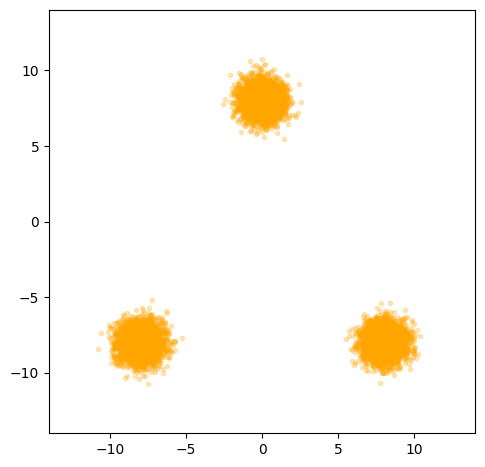

In [74]:
plot(model_3, X_3, limit=14, mode="data_only")

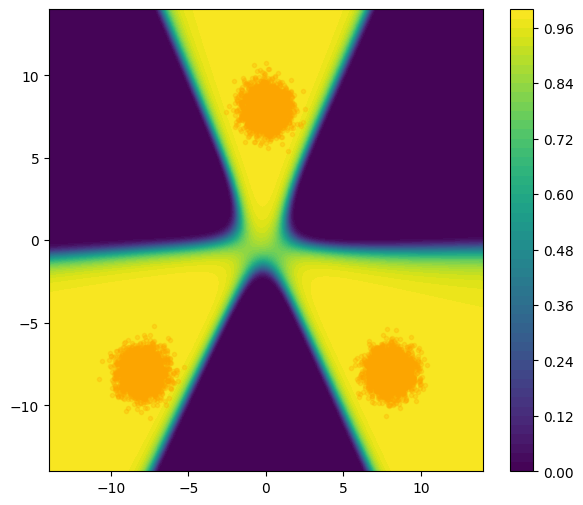

In [75]:
plot(model_3, X_3, limit=14)

In [76]:
X_4 = generate_data(n_modes=4)
model_4 = train_model(X_4, verbose=False)

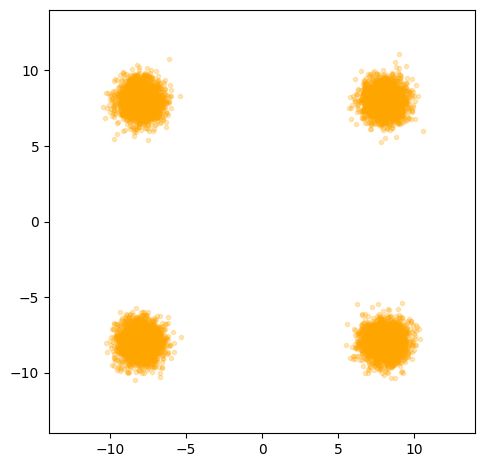

In [77]:
plot(model_4, X_4, limit=14, mode="data_only")

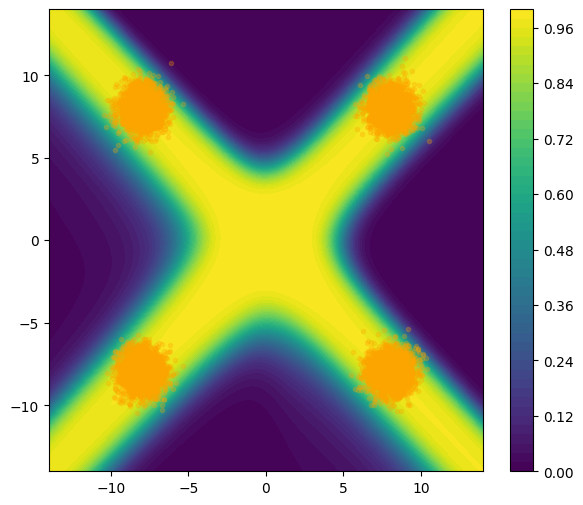

In [78]:
plot(model_4, X_4, limit=14)

# Normalizing Flows - Invertible Neural Networks (INNs)

## Librairies

In [153]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
from scipy.stats import multivariate_normal

import matplotlib.pyplot as plt

## Dataset

In [222]:
torch.manual_seed(42)

def generate_data(n=10000, x=8, n_modes=4):

    if n_modes == 1:
        modes = [(0, 0)]

    elif n_modes == 2:
        modes = [(-x, -x), 
                 (x, x)]
        
    elif n_modes == 3:
        modes = [(-x, -x), 
                 (x, -x),
                 (0, x)]
         
    elif n_modes == 4:
        modes = [(-x, -x), 
                 (x, x), 
                 (-x, x), 
                 (x, -x)]
    cov = 0.99 * np.eye(2)
    data = []
    for cx, cy in modes:
        samples = np.random.multivariate_normal([cx, cy], cov, n // len(modes))
        data.append(samples)
        
    X = torch.from_numpy(np.vstack(data))
    return X.to(torch.float32)

In [223]:
X_train = generate_data(n=10000, x=8, n_modes=4)

## Model

In [229]:
# ==== RealNVP Building Blocks ====
class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, in_dim)
        )
    def forward(self, x):
        return self.net(x)

class RealNVP(nn.Module):
    def __init__(self, dim, num_flows=6):
        super().__init__()
        self.dim = dim
        self.masks = [torch.tensor([i % 2, (i+1) % 2], dtype=torch.float32) for i in range(num_flows)]
        self.s = nn.ModuleList([MLP(dim) for _ in range(num_flows)])
        self.t = nn.ModuleList([MLP(dim) for _ in range(num_flows)])
        self.base_dist = torch.distributions.MultivariateNormal(torch.zeros(dim), torch.eye(dim))

    def forward(self, x):
        log_det = torch.zeros(x.size(0))
        z = x
        for i in range(len(self.s)):
            mask = self.masks[i].to(x.device)
            s = self.s[i](z * mask) * (1 - mask)
            t = self.t[i](z * mask) * (1 - mask)
            z = z * torch.exp(s) + t
            log_det += s.sum(dim=1)
        return z, log_det

    def inverse(self, z):
        x = z
        for i in reversed(range(len(self.s))):
            mask = self.masks[i].to(z.device)
            s = self.s[i](x * mask) * (1 - mask)
            t = self.t[i](x * mask) * (1 - mask)
            x = (x - t) * torch.exp(-s)
        return x

    def log_prob(self, x):
        z, log_det = self.forward(x)
        # z = torch.where(torch.isfinite(z), z, torch.full_like(z, -20.0))  # clipping values!
        return self.base_dist.log_prob(z) + log_det

In [230]:
# ==== Train ====
model = RealNVP(dim=2, num_flows=6)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

n_epochs = 3000
batch_size = 256

for epoch in range(n_epochs):
    idx = np.random.choice(len(X_train), batch_size)
    x_batch = X_train[idx]
    loss = -model.log_prob(x_batch).mean()

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0) # for numercial instabilities
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

Epoch 100, Loss: 8.4530
Epoch 200, Loss: 7.0356
Epoch 300, Loss: 6.3184
Epoch 400, Loss: 5.7478
Epoch 500, Loss: 5.6303
Epoch 600, Loss: 5.2963
Epoch 700, Loss: 5.2387
Epoch 800, Loss: 5.2901
Epoch 900, Loss: 5.0685
Epoch 1000, Loss: 5.1682
Epoch 1100, Loss: 5.1829
Epoch 1200, Loss: 4.9520
Epoch 1300, Loss: 5.0112
Epoch 1400, Loss: 4.9521
Epoch 1500, Loss: 4.8938
Epoch 1600, Loss: 4.9435
Epoch 1700, Loss: 4.7948
Epoch 1800, Loss: 4.8046
Epoch 1900, Loss: 4.7683
Epoch 2000, Loss: 4.7913
Epoch 2100, Loss: 4.7064
Epoch 2200, Loss: 4.7088
Epoch 2300, Loss: 4.7012
Epoch 2400, Loss: 4.6625
Epoch 2500, Loss: 4.7021
Epoch 2600, Loss: 4.7734
Epoch 2700, Loss: 4.6527
Epoch 2800, Loss: 4.6840
Epoch 2900, Loss: 4.6511
Epoch 3000, Loss: 4.6613


## Results

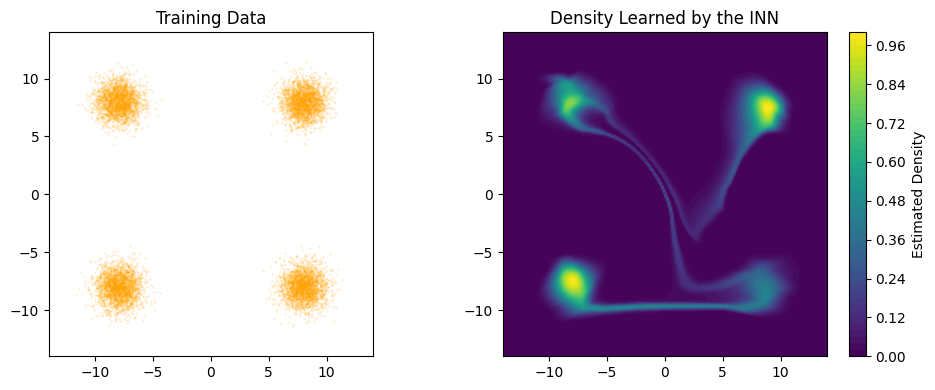

In [231]:
# Evaluate density on a grid
x = np.linspace(-14, 14, 200)
y = np.linspace(-14, 14, 200)
X, Y = np.meshgrid(x, y)
grid = np.stack([X.ravel(), Y.ravel()], axis=1)
grid_tensor = torch.tensor(grid, dtype=torch.float32)

with torch.no_grad():
    log_probs = model.log_prob(grid_tensor).numpy()
    probs = np.exp(log_probs - log_probs.max()).reshape(X.shape) # Normalize for plotting!
    
# Create side-by-side plots
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# First plot: Data only
axs[0].scatter(X_train[:, 0], X_train[:, 1], s=1, alpha=0.1, color='orange')
axs[0].set_title('Training Data')
axs[0].set_xlim(-14, 14)
axs[0].set_ylim(-14, 14)
axs[0].set_aspect('equal')

# Second plot: Estimated density
density = axs[1].contourf(X, Y, probs, levels=50, cmap='viridis')
fig.colorbar(density, ax=axs[1], label='Estimated Density')
axs[1].set_title('Density Learned by the INN')
axs[1].set_xlim(-14, 14)
axs[1].set_ylim(-14, 14)
axs[1].set_aspect('equal')

plt.tight_layout()
plt.show()